<a href="https://colab.research.google.com/github/georgespecial/mpi_matrix_multiplication/blob/main/mpi_matrix_multiplication_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mpi4py


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 466.2/466.2 kB 8.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mpi4py: filename=mpi4py-4.0.1-cp310-cp310-linux_x86_64.whl size=4266353 sha256=f080da6e5d4daa78de2aa16339bc0b7d6cc8b83c6cb8a2cdd1993d3ebe65a8c1
  Stored in directory: /root/.cache/pip/wheels/3c/ca/13/13218a83854023ccec184e3af482f0f038b434aa32c19afee8
Successfully built mpi4py


In [ ]:
from mpi4py import MPI
import numpy as np
import time

# Функция для инициализации матрицы
def initialize_matrix(n, is_a=True):
    if is_a:
        return np.array([[1.0 + ((i + j) % 100) * 0.01 for j in range(n)] for i in range(n)], dtype=np.float64)
    else:
        return np.array([[2.0 + ((i - j + 100) % 100) * 0.01 for j in range(n)] for i in range(n)], dtype=np.float64)

# Основной код
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

N = 3000  # Размер матрицы
rows_per_process = N // size
remainder = N % size
local_rows = rows_per_process + (1 if rank < remainder else 0)

# Подготовка данных
A_local = np.zeros((local_rows, N), dtype=np.float64)
B_local = np.zeros((N, N), dtype=np.float64) if rank == 0 else None
C_local = np.zeros((local_rows, N), dtype=np.float64)

# Инициализация матриц в корневом процессе
if rank == 0:
    A = initialize_matrix(N, is_a=True)
    B = initialize_matrix(N, is_a=False)
else:
    A = None
    B = None

# Распределение строк матрицы A
sendcounts = [(rows_per_process + (1 if i < remainder else 0)) * N for i in range(size)]
displs = [sum(sendcounts[:i]) for i in range(size)]
comm.Scatterv([A, sendcounts, displs, MPI.DOUBLE], A_local, root=0)

# Рассылка полной матрицы B
B_local = comm.bcast(B, root=0)

# Умножение локальных частей матриц
start_time = comm.barrier() or time.time()
for i in range(local_rows):
    for j in range(N):
        C_local[i, j] = np.dot(A_local[i, :], B_local[:, j])
end_time = comm.barrier() or time.time()

# Сбор результатов
recvcounts = sendcounts
recvdispls = displs
C = None
if rank == 0:
    C = np.zeros((N, N), dtype=np.float64)
comm.Gatherv(C_local, [C, recvcounts, recvdispls, MPI.DOUBLE], root=0)

# Вывод результата в корневом процессе
if rank == 0:
    total_time = end_time - start_time

    # Анализ результатов
    print(f"\nЧисло процессов: {size}")
    print(f"Общее время выполнения: {total_time:.6f} секунд")

    if C is not None:
        # Вывод первых 20 элементов результата
        print("Первые 20 элементов результата:")
        print(C.flatten()[:20])

        # Проверка максимального элемента
        max_element = np.max(C)
        print(f"Максимальный элемент в результирующей матрице: {max_element}")

        # Угловые элементы
        print("Угловые элементы матрицы C:")
        print(f"C[0][0]: {C[0, 0]}")
        print(f"C[0][{N - 1}]: {C[0, N - 1]}")
        print(f"C[{N - 1}][0]: {C[N - 1, 0]}")
        print(f"C[{N - 1}][{N - 1}]: {C[N - 1, N - 1]}")

        # Сохранение результата для анализа
        with open("mpi_results.txt", "a") as f:
            f.write(f"{size},{total_time:.6f}\n")



Число процессов: 1
Общее время выполнения: 427.283137 секунд
Первые 20 элементов результата:
[11440.05 11425.2  11410.65 11396.4  11382.45 11368.8  11355.45 11342.4
 11329.65 11317.2  11305.05 11293.2  11281.65 11270.4  11259.45 11248.8
 11238.45 11228.4  11218.65 11209.2 ]
Максимальный элемент в результирующей матрице: 11440.050000000027
Угловые элементы матрицы C:
C[0][0]: 11440.050000000016
C[0][2999]: 11425.199999999984
C[2999][0]: 11425.199999999997
C[2999][2999]: 11410.649999999987


In [ ]:
!mpirun --allow-run-as-root -np 10 -x OMPI_ALLOW_RUN_AS_ROOT=1 -x OMPI_ALLOW_RUN_AS_ROOT_CONFIRM=1 python mpi_matrix_multiplication.py




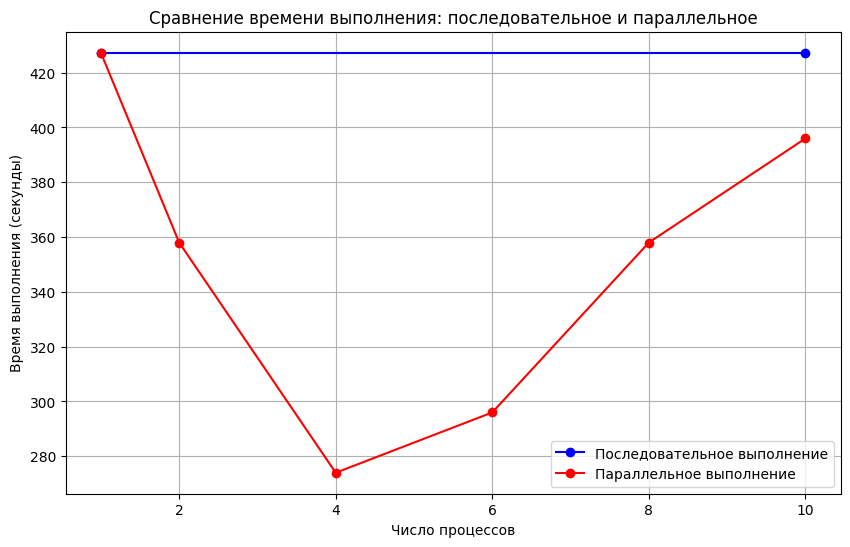

In [ ]:
import matplotlib.pyplot as plt

# Данные
processes = [1, 2, 4, 6, 8, 10]  # Число процессов
execution_time = [427.28, 358.0, 274.0, 296.0, 358.0, 396.0]  # Время выполнения в секундах

# Построение графика
plt.figure(figsize=(10, 6))

# График последовательного выполнения
plt.plot([1, max(processes)], [427.28, 427.28], label="Последовательное выполнение",
         color="blue", marker="o")

# График параллельного выполнения
plt.plot(processes, execution_time, label="Параллельное выполнение", color="red", marker="o")

# Добавление подписей и настроек
plt.title("Сравнение времени выполнения: последовательное и параллельное")
plt.xlabel("Число процессов")
plt.ylabel("Время выполнения (секунды)")
plt.legend()
plt.grid(True)

# Отображение графика
plt.show()

